In [270]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import zscore
from scipy.stats import stats
from scipy.stats import linregress
import os
import seaborn as sns
import re
import datetime
import nbconvert
import glob
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import chart_studio as py

from config import username,plotly_api_key
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Files to Load (csv files downloaded from the internet)

# Country information files
file1 = "data/unsd.csv"
file2 = "data/six-dem_mod.csv"

# Covid Case timeseries file
file3 = "data/covid-confirmed-cases-since-100th-case_hkg.csv"
file4 = "data/worldometer.csv"

# Country timeseries files
file5 = "data/population-density-vs-prosperity.csv"
file6 = "data/urban-and-rural-population.csv"
file7 = "data/urban-vs-rural-majority.csv"
file8 = "data/life-expectancy-at-birth-total-years.csv"
file9 = "data/median-age.csv"

# Read File and store into Pandas data frame
unsd = pd.read_csv(file1)
hoefstede = pd.read_csv(file2)

covid_data = pd.read_csv(file3, parse_dates=['Date'])
wom = pd.read_csv(file4,parse_dates=['date'])

density_vs_prosperity = pd.read_csv(file5)
urban_rural_population = pd.read_csv(file6)
urban_vs_rural_majority = pd.read_csv(file7)
life_expectancy = pd.read_csv(file8)
median_age = pd.read_csv(file9)


# Create 'countries' dataframe with all country information
#### This is in Tidy format

In [3]:
unsd.columns

Index(['Global Code', 'Global Name', 'Region Code', 'Region Name',
       'Sub-region Code', 'Sub-region Name', 'Intermediate Region Code',
       'Intermediate Region Name', 'Country or Area', 'M49 Code', 'Code',
       'Least Developed Countries (LDC)',
       'Land Locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)',
       'Developed / Developing Countries'],
      dtype='object')

In [4]:
#Format columns
unsd = unsd.rename(columns={"Global Code":"globalCode",
                            "Global Name":"globalName",
                            'Region Code':"regionCode",
                            'Region Name':"regionName",
                            'Sub-region Code':"subRegionCode",
                            'Sub-region Name':"subRegionName",
                            'Intermediate Region Code':"interRegionCode",
                            'Intermediate Region Name':"interRegionName",
                            'Country or Area':"country",
                            'M49 Code':"m49",
                            'Code':"code",
                            'Least Developed Countries (LDC)':"ldc",
                            'Land Locked Developing Countries (LLDC)':"lldc",
                            'Small Island Developing States (SIDS)':"sids",
                            'Developed / Developing Countries':"development"
                            })

In [5]:
unsd.drop(columns=['interRegionCode','interRegionName'])

globalCode globalName  regionCode regionName  subRegionCode  \
0             1      World         142       Asia             34   
1             1      World         150     Europe            154   
2             1      World         150     Europe             39   
3             1      World           2     Africa             15   
4             1      World           9    Oceania             61   
5             1      World         150     Europe             39   
6             1      World           2     Africa            202   
7             1      World          19   Americas            419   
8             1      World          10  Antartica            100   
9             1      World          19   Americas            419   
10            1      World          19   Americas            419   
11            1      World         142       Asia            145   
12            1      World          19   Americas            419   
13            1      World           9    Oceania             53   
14            1      World         150     Europe            155   
15            1      World         142       Asia            145   
16            1      World          19   Americas            419   
17            1      World         142       Asia            145   
18            1      World         142       Asia             34   
19            1      World          19   Americas            419   
20            1      World         150     Europe            151   
21            1      World         150     Europe            155   
22            1      World          19   Americas            419   
23            1      World           2     Africa            202   
24            1      World          19   Americas             21   
25            1      World         142       Asia             34   
26            1      World          19   Americas            419   
27            1      World          19   Americas            419   
28            1      World         150     Europe             39   
29            1      World           2     Africa            202   
..          ...        ...         ...        ...            ...   
220           1      World         142       Asia            143   
221           1      World           9    Oceania             57   
222           1      World         142       Asia             35   
223           1      World         142       Asia             35   
224           1      World           2     Africa            202   
225           1      World           9    Oceania             61   
226           1      World           9    Oceania             61   
227           1      World          19   Americas            419   
228           1      World           2     Africa             15   
229           1      World         142       Asia            145   
230           1      World         142       Asia            143   
231           1      World          19   Americas            419   
232           1      World           9    Oceania             61   
233           1      World         142       Asia            145   
234           1      World           2     Africa            202   
235           1      World         150     Europe            154   
236           1      World         150     Europe            151   
237           1      World           9    Oceania             57   
238           1      World          19   Americas            419   
239           1      World          19   Americas            419   
240           1      World          19   Americas             21   
241           1      World         142       Asia            143   
242           1      World           9    Oceania             54   
243           1      World          19   Americas            419   
244           1      World         142       Asia             35   
245           1      World           9    Oceania             61   
246           1      World           2     Africa            

In [6]:
hoefstede.columns

Index(['ctr', 'country', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr'], dtype='object')

In [7]:
#Format columns
hoefstede = hoefstede.rename(columns={"ctr":"code"
                            })

In [8]:
hoefstede = hoefstede.replace('#NULL!','')

In [9]:
hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']] = hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']].apply(pd.to_numeric)

In [10]:
hoefstede.head()

code    country   pdi   idv   mas    uai  ltowvs    ivr
0  GTM  Guatemala  95.0   6.0  37.0  101.0     NaN    NaN
1  ECU    Ecuador  78.0   8.0  63.0   67.0     NaN    NaN
2  PAN     Panama  95.0  11.0  44.0   86.0     NaN    NaN
3  VEN  Venezuela  81.0  12.0  73.0   76.0    16.0  100.0
4  COL   Colombia  67.0  13.0  64.0   80.0    13.0   83.0

In [11]:
# Merge data
countries = pd.merge(unsd, hoefstede, on=["code"])
countries.shape

(118, 22)

In [12]:
countries.columns

Index(['globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country_x',
       'm49', 'code', 'ldc', 'lldc', 'sids', 'development', 'country_y', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr'],
      dtype='object')

In [13]:
countries.drop(['country_y'], axis=1,inplace=True)

In [14]:
countries = countries.rename(columns={'country_x': 'country'})

In [15]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 21 columns):
globalCode         118 non-null int64
globalName         118 non-null object
regionCode         118 non-null int64
regionName         118 non-null object
subRegionCode      118 non-null int64
subRegionName      118 non-null object
interRegionCode    38 non-null float64
interRegionName    36 non-null object
country            118 non-null object
m49                118 non-null int64
code               118 non-null object
ldc                17 non-null float64
lldc               15 non-null float64
sids               7 non-null float64
development        118 non-null object
pdi                102 non-null float64
idv                102 non-null float64
mas                102 non-null float64
uai                102 non-null float64
ltowvs             97 non-null float64
ivr                95 non-null float64
dtypes: float64(10), int64(4), object(7)
memory usage: 20.3+ KB


In [16]:
# Export CSV
countries.to_csv('countries.csv')  

In [17]:
# Create multiindex using unsd naming conventions
#countries = countries.set_index(['globalName','regionName','subRegionName','code'])

In [18]:
countries.head()

globalCode globalName  regionCode regionName  subRegionCode  \
0           1      World         150     Europe             39   
1           1      World           2     Africa             15   
2           1      World         150     Europe             39   
3           1      World           2     Africa            202   
4           1      World          19   Americas            419   

                     subRegionName  interRegionCode interRegionName  \
0                  Southern Europe              NaN             NaN   
1                  Northern Africa              NaN             NaN   
2                  Southern Europe              NaN             NaN   
3               Sub-Saharan Africa             17.0   Middle Africa   
4  Latin America and the Caribbean              5.0   South America   

     country  m49  ...  ldc  lldc  sids  development   pdi   idv   mas   uai  \
0    Albania    8  ...  NaN   NaN   NaN    Developed  90.0  20.0  80.0  70.0   
1    Algeria   12  ...  NaN   NaN   NaN   Developing   NaN   NaN   NaN   NaN   
2    Andorra   20  ...  NaN   NaN   NaN    Developed   NaN   NaN   NaN   NaN   
3     Angola   24  ...  1.0   NaN   NaN   Developing  83.0  18.0  20.0  60.0   
4  Argentina   32  ...  NaN   NaN   NaN   Developing  49.0  46.0  56.0  86.0   

   ltowvs   ivr  
0    61.0  15.0  
1    26.0  32.0  
2     NaN  65.0  
3    15.0  83.0  
4    20.0  62.0  

[5 rows x 21 columns]

# Create 'covid' dataframe with timeseries & confirmed cases

In [19]:
covid_data.columns

Index(['Entity', 'Code', 'Date', ' (cases)',
       'Number of days since the 100th confirmed case (days)'],
      dtype='object')

In [20]:
covid_data.head()

Entity Code       Date   (cases)  \
0  Afghanistan  AFG 2019-12-31       0.0   
1  Afghanistan  AFG 2020-01-01       0.0   
2  Afghanistan  AFG 2020-01-02       0.0   
3  Afghanistan  AFG 2020-01-03       0.0   
4  Afghanistan  AFG 2020-01-04       0.0   

   Number of days since the 100th confirmed case (days)  
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN

In [21]:
#Format columns
covid = covid_data.rename(columns={'Entity': "country",
                              'Code' : "code",
                              'Date': "date",
                              ' (cases)' : "cases",
                              'Number of days since the 100th confirmed case (days)':"daysGT100"
                                         })
covid = covid[['code','country','date','cases','daysGT100']]

In [22]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12768 entries, 0 to 12767
Data columns (total 5 columns):
code         11092 non-null object
country      12768 non-null object
date         12768 non-null datetime64[ns]
cases        12761 non-null float64
daysGT100    4459 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 498.8+ KB


In [23]:
covid.head()

code      country       date  cases  daysGT100
0  AFG  Afghanistan 2019-12-31    0.0        NaN
1  AFG  Afghanistan 2020-01-01    0.0        NaN
2  AFG  Afghanistan 2020-01-02    0.0        NaN
3  AFG  Afghanistan 2020-01-03    0.0        NaN
4  AFG  Afghanistan 2020-01-04    0.0        NaN

In [24]:
covidGT100 = covid[covid['daysGT100'] >= 0]
covidGT100.dropna(subset=['code'],inplace=True)

In [25]:
covidGT100['logCases'] = np.log(covidGT100['cases'])

In [26]:
covidGT100.to_csv('covidGT100.csv')

In [27]:
# Merge data
covidGT100Hoef = pd.merge(covidGT100, hoefstede, on=["code"])
covidGT100Hoef.shape

(2940, 13)

In [28]:
covidGT100Hoef.drop(['country_y'], axis=1,inplace=True)

In [29]:
covidGT100Hoef.head()

code country_x       date  cases  daysGT100  logCases   pdi   idv   mas  \
0  ALB   Albania 2020-03-24  100.0        0.0  4.605170  90.0  20.0  80.0   
1  ALB   Albania 2020-03-25  123.0        1.0  4.812184  90.0  20.0  80.0   
2  ALB   Albania 2020-03-26  146.0        2.0  4.983607  90.0  20.0  80.0   
3  ALB   Albania 2020-03-27  174.0        3.0  5.159055  90.0  20.0  80.0   
4  ALB   Albania 2020-03-28  186.0        4.0  5.225747  90.0  20.0  80.0   

    uai  ltowvs   ivr  
0  70.0    61.0  15.0  
1  70.0    61.0  15.0  
2  70.0    61.0  15.0  
3  70.0    61.0  15.0  
4  70.0    61.0  15.0

In [30]:
covidGT100Hoef = covidGT100Hoef.rename(columns={"country_x": "country"})

In [31]:
covidGT100Hoef.head()

code  country       date  cases  daysGT100  logCases   pdi   idv   mas  \
0  ALB  Albania 2020-03-24  100.0        0.0  4.605170  90.0  20.0  80.0   
1  ALB  Albania 2020-03-25  123.0        1.0  4.812184  90.0  20.0  80.0   
2  ALB  Albania 2020-03-26  146.0        2.0  4.983607  90.0  20.0  80.0   
3  ALB  Albania 2020-03-27  174.0        3.0  5.159055  90.0  20.0  80.0   
4  ALB  Albania 2020-03-28  186.0        4.0  5.225747  90.0  20.0  80.0   

    uai  ltowvs   ivr  
0  70.0    61.0  15.0  
1  70.0    61.0  15.0  
2  70.0    61.0  15.0  
3  70.0    61.0  15.0  
4  70.0    61.0  15.0

In [32]:
# Merge data
covidGT100Hoef = pd.merge(covidGT100, countries, on=["code"])
covidGT100Hoef.shape

(2940, 26)

In [33]:
covidGT100Hoef.columns

Index(['code', 'country_x', 'date', 'cases', 'daysGT100', 'logCases',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country_y',
       'm49', 'ldc', 'lldc', 'sids', 'development', 'pdi', 'idv', 'mas', 'uai',
       'ltowvs', 'ivr'],
      dtype='object')

In [34]:
covidGT100Hoef.drop(['country_y'], axis=1,inplace=True)
covidGT100Hoef = covidGT100Hoef.rename(columns={"country_x": "country"})

In [35]:
covidGT100Hoef = pd.merge(covidGT100Hoef, wom, on=["code"])
covidGT100Hoef.shape

(2922, 37)

In [36]:
covidGT100Hoef.columns

Index(['code', 'country', 'date_x', 'cases', 'daysGT100', 'logCases',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'm49', 'ldc',
       'lldc', 'sids', 'development', 'pdi', 'idv', 'mas', 'uai', 'ltowvs',
       'ivr', 'countryWom', 'date_y', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop'],
      dtype='object')

In [37]:
covidGT100Hoef.drop(['date_y'], axis=1,inplace=True)
covidGT100Hoef = covidGT100Hoef.rename(columns={'date_x':"date"})

In [38]:
covidGT100Hoef.columns

Index(['code', 'country', 'date', 'cases', 'daysGT100', 'logCases',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'm49', 'ldc',
       'lldc', 'sids', 'development', 'pdi', 'idv', 'mas', 'uai', 'ltowvs',
       'ivr', 'countryWom', 'totalCases', 'totalDeaths', 'totalRecovered',
       'activeCases', 'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests',
       'testsMPop', 'calcPop'],
      dtype='object')

In [39]:
covidGT100Hoef['casesPop'] = (covidGT100Hoef['cases']/covidGT100Hoef['calcPop'])
covidGT100Hoef['logCasesPop'] = np.log(covidGT100Hoef['cases']/covidGT100Hoef['calcPop'])
covidGT100Hoef['logCasesMPop'] = np.log(covidGT100Hoef['casesMPop'])

In [40]:
covidGT100Hoef.head()

code  country       date  cases  daysGT100  logCases  globalCode globalName  \
0  ALB  Albania 2020-03-24  100.0        0.0  4.605170           1      World   
1  ALB  Albania 2020-03-25  123.0        1.0  4.812184           1      World   
2  ALB  Albania 2020-03-26  146.0        2.0  4.983607           1      World   
3  ALB  Albania 2020-03-27  174.0        3.0  5.159055           1      World   
4  ALB  Albania 2020-03-28  186.0        4.0  5.225747           1      World   

   regionCode regionName  ...  activeCases criticalCases  casesMPop  \
0         150     Europe  ...          218           5.0      172.0   
1         150     Europe  ...          218           5.0      172.0   
2         150     Europe  ...          218           5.0      172.0   
3         150     Europe  ...          218           5.0      172.0   
4         150     Europe  ...          218           5.0      172.0   

  deathsMPop  totalTests  testsMPop  calcPop  casesPop logCasesPop  \
0        9.0      4558.0     1584.0  2872093  0.000035  -10.265381   
1        9.0      4558.0     1584.0  2872093  0.000043  -10.058367   
2        9.0      4558.0     1584.0  2872093  0.000051   -9.886945   
3        9.0      4558.0     1584.0  2872093  0.000061   -9.711496   
4        9.0      4558.0     1584.0  2872093  0.000065   -9.644805   

   logCasesMPop  
0      5.147494  
1      5.147494  
2      5.147494  
3      5.147494  
4      5.147494  

[5 rows x 39 columns]

# Create Worldometer dataframe

In [230]:
wom.head()

countryWom code       date  totalCases  totalDeaths  totalRecovered  \
0      Zimbabwe  ZWE 2020-04-15          23          3.0             1.0   
1        Zambia  ZMB 2020-04-15          48          2.0            30.0   
2  South Africa  ZAF 2020-04-15        2506         34.0           410.0   
3         Yemen  YEM 2020-04-15           1          NaN             NaN   
4       Vietnam  VNM 2020-04-15         268          NaN           171.0   

   activeCases  criticalCases  casesMPop  deathsMPop  totalTests  testsMPop  \
0           19            NaN       2.00         0.2       716.0       48.0   
1           16            1.0       3.00         0.1      1696.0       92.0   
2         2062            7.0      42.00         0.6     90515.0     1526.0   
3            1            NaN       0.03         NaN         NaN        NaN   
4           97            8.0       3.00         NaN    135938.0     1397.0   

    calcPop  
0  11500000  
1  16000000  
2  59666667  
3  33333333  
4  89333333

In [231]:
womHoef = pd.merge(wom, hoefstede, on=["code"])
womHoef.shape

(116, 20)

In [232]:
womHoef['casesPop'] = (womHoef['totalCases']/womHoef['calcPop'])
womHoef['logCasesPop'] = np.log(womHoef['totalCases']/womHoef['calcPop'])
womHoef['logCasesMPop'] = np.log(womHoef['casesMPop'])

In [233]:
womHoef.head()

countryWom code       date  totalCases  totalDeaths  totalRecovered  \
0      Zimbabwe  ZWE 2020-04-15          23          3.0             1.0   
1        Zambia  ZMB 2020-04-15          48          2.0            30.0   
2  South Africa  ZAF 2020-04-15        2506         34.0           410.0   
3       Vietnam  VNM 2020-04-15         268          NaN           171.0   
4     Venezuela  VEN 2020-04-15         197          9.0           111.0   

   activeCases  criticalCases  casesMPop  deathsMPop  ...       country   pdi  \
0           19            NaN        2.0         0.2  ...      Zimbabwe   NaN   
1           16            1.0        3.0         0.1  ...        Zambia  60.0   
2         2062            7.0       42.0         0.6  ...  South Africa  49.0   
3           97            8.0        3.0         NaN  ...       Vietnam  70.0   
4           77            6.0        7.0         0.3  ...     Venezuela  81.0   

    idv   mas   uai  ltowvs    ivr  casesPop  logCasesPop  logCasesMPop  
0   NaN   NaN   NaN    15.0   28.0  0.000002   -13.122363      0.693147  
1  35.0  40.0  50.0    30.0   42.0  0.000003   -12.716898      1.098612  
2  65.0  63.0  49.0    34.0   63.0  0.000042   -10.077841      3.737670  
3  20.0  40.0  30.0    57.0   35.0  0.000003   -12.716898      1.098612  
4  12.0  73.0  76.0    16.0  100.0  0.000007   -11.869600      1.945910  

[5 rows x 23 columns]

In [234]:
womHoef.to_csv('womHoef.csv')

In [235]:

covidMaxDays = covidGT100Hoef.groupby(['code'], sort=False)['daysGT100'].max()


In [236]:
womHoef.columns

Index(['countryWom', 'code', 'date', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'country', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'casesPop', 'logCasesPop',
       'logCasesMPop'],
      dtype='object')

In [237]:
womHoef = pd.merge(womHoef, covidMaxDays, on=['code'])

In [238]:
womHoef.columns

Index(['countryWom', 'code', 'date', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'country', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'casesPop', 'logCasesPop',
       'logCasesMPop', 'daysGT100'],
      dtype='object')

# Create Merged dataframe

In [50]:
density_vs_prosperity.shape

(47234, 6)

In [51]:
density_vs_prosperity.dropna(subset=['Code'],inplace=True)
density_vs_prosperity.shape

(44392, 6)

In [52]:
urban_rural_population.dropna(subset=['Code'],inplace=True)
urban_rural_population.shape

(12363, 5)

In [53]:
urban_vs_rural_majority.dropna(subset=['Code'],inplace=True)
urban_vs_rural_majority.shape

(24019, 5)

In [54]:
life_expectancy.dropna(subset=['Code'],inplace=True)
life_expectancy.shape

(11125, 4)

In [55]:
median_age.dropna(subset=['Code'],inplace=True)
median_age.shape

(6324, 4)

In [56]:
# Merge data
merged_data = pd.merge(density_vs_prosperity, urban_rural_population, on=["Entity","Code", "Year"])
merged_data.shape

(12283, 8)

In [57]:
merged_data = pd.merge(merged_data, urban_vs_rural_majority, on=["Entity", "Code", "Year"])
merged_data.shape

(12283, 10)

In [58]:
merged_data = pd.merge(merged_data, life_expectancy, on=["Entity", "Code", "Year"])
merged_data.shape

(11007, 11)

In [59]:
merged_data = pd.merge(merged_data, median_age, on=["Entity", "Code", "Year"])
merged_data.shape

(2280, 12)

In [60]:
merged_data.columns

Index(['Entity', 'Code', 'Year',
       'Population density (people per km² of land area)',
       'GDP per capita (constant 2011 international $)',
       'Total population (Gapminder)', 'Urban population', 'Rural population',
       'Urban (%)', 'Rural (%)',
       'Life expectancy at birth, total (years) (years)',
       'UN Population Division (Median Age) (2017) (years)'],
      dtype='object')

In [61]:
#Format columns
merged_data = merged_data.rename(columns={'Code':'code',
                                          'Year':'date',
                                          "Population density (people per km² of land area)": "popDensity",
                                          "GDP per capita (constant 2011 international $)" : "gdp",
                                         "Total population (Gapminder)": "gapPop",
                                         "Urban population": "urbanPop",
                                         "Rural population": "ruralPop",
                                         "Urban (%)":"urbanPct",
                                         "Rural (%)": "ruralPct",
                                         "Life expectancy at birth, total (years) (years)":"lifeExpectancy",
                                         "UN Population Division (Median Age) (2017) (years)":"medianAge"
                                         })

In [62]:
unsd.columns

Index(['globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'code', 'ldc', 'lldc', 'sids', 'development'],
      dtype='object')

In [63]:
merged_data = pd.merge(merged_data, unsd, on=["code"])
merged_data.columns

Index(['Entity', 'code', 'date', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development'],
      dtype='object')

In [64]:
merged_data = pd.merge(merged_data, wom, on=["code"])
merged_data.shape

(2057, 38)

In [65]:
merged_data.columns

Index(['Entity', 'code', 'date_x', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development', 'countryWom', 'date_y',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop'],
      dtype='object')

In [66]:
merged_data.drop(['date_y'], axis=1,inplace=True)
merged_data = merged_data.rename(columns={"date_x":'date'})

In [67]:
merged_data.columns

Index(['Entity', 'code', 'date', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop'],
      dtype='object')

In [68]:
merged_data = pd.merge(merged_data, hoefstede, on=[ "code"])
merged_data.head()

Entity code  date  popDensity  gdp     gapPop  urbanPop  ruralPop  \
0  Albania  ALB  1960         NaN  NaN  1636056.0    493982   1114818   
1  Albania  ALB  1965   68.058066  NaN  1896125.0    582374   1282417   
2  Albania  ALB  1970   77.937190  NaN  2150598.0    677801   1457678   
3  Albania  ALB  1975   87.767555  NaN  2411229.0    786668   1618163   
4  Albania  ALB  1980   97.518139  NaN  2681239.0    902120   1769877   

   urbanPct   ruralPct  ...  totalTests  testsMPop  calcPop country_y   pdi  \
0    30.705  69.294998  ...      4558.0     1584.0  2872093   Albania  90.0   
1    31.230  68.769997  ...      4558.0     1584.0  2872093   Albania  90.0   
2    31.740  68.260002  ...      4558.0     1584.0  2872093   Albania  90.0   
3    32.712  67.288002  ...      4558.0     1584.0  2872093   Albania  90.0   
4    33.762  66.237999  ...      4558.0     1584.0  2872093   Albania  90.0   

    idv   mas   uai  ltowvs   ivr  
0  20.0  80.0  70.0    61.0  15.0  
1  20.0  80.0  70.0    61.0  15.0  
2  20.0  80.0  70.0    61.0  15.0  
3  20.0  80.0  70.0    61.0  15.0  
4  20.0  80.0  70.0    61.0  15.0  

[5 rows x 44 columns]

In [69]:
merged_data.drop(['country_y'], axis=1,inplace=True)

In [70]:
merged_data = merged_data.rename(columns={"country_x":'country'})

In [71]:
#merged_data['date']

In [72]:
merged_data['date'].max()

2015

In [73]:
merged_data = merged_data[merged_data['date'] == 2015]
#merged_data.head()

In [74]:
merged_data.columns

Index(['Entity', 'code', 'date', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr'],
      dtype='object')

In [75]:
merged_data.head()

Entity code  date  popDensity           gdp      gapPop  urbanPop  \
11    Albania  ALB  2015  105.135146  10970.452245   2923352.0   1654503   
23    Algeria  DZA  2015   16.740504  13724.723853  39871528.0  28248180   
35     Angola  AGO  2015   22.346439   6227.664689  27859305.0  17675615   
47  Argentina  ARG  2015   15.865065  19116.907915  43417765.0  39728558   
59    Armenia  ARM  2015  102.456972   8195.933650   2916950.0   1840158   

    ruralPop  urbanPct   ruralPct  ...  deathsMPop  totalTests  testsMPop  \
11   1226200    57.434  42.566002  ...        9.00      4558.0     1584.0   
23  11623348    70.848  29.152000  ...        8.00      3359.0       77.0   
35  10183690    63.446  36.554001  ...        0.06         NaN        NaN   
47   3689207    91.503   8.497000  ...        2.00     24374.0      539.0   
59   1076792    63.085  36.915001  ...        6.00      9095.0     3069.0   

     calcPop   pdi   idv   mas   uai  ltowvs   ivr  
11   2872093  90.0  20.0  80.0  70.0    61.0  15.0  
23  44081633   NaN   NaN   NaN   NaN    26.0  32.0  
35  31666667  83.0  18.0  20.0  60.0    15.0  83.0  
47  45105263  49.0  46.0  56.0  86.0    20.0  62.0  
59   2962667   NaN   NaN   NaN   NaN    61.0   NaN  

[5 rows x 43 columns]

In [76]:
merged_data.columns

Index(['Entity', 'code', 'date', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr'],
      dtype='object')

In [77]:
merged_data.shape

(114, 43)

In [78]:
# Export CSV
merged_data.to_csv('mergetest.csv')  

In [79]:
#merged_data.info()

In [80]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12768 entries, 0 to 12767
Data columns (total 5 columns):
code         11092 non-null object
country      12768 non-null object
date         12768 non-null datetime64[ns]
cases        12761 non-null float64
daysGT100    4459 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 498.8+ KB


In [81]:
merged_data = pd.merge(merged_data, covid, on=[ "code"])
merged_data.columns

Index(['Entity', 'code', 'date_x', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country_x',
       'm49', 'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y', 'date_y', 'cases',
       'daysGT100'],
      dtype='object')

In [82]:
merged_data.drop(['date_x'], axis=1,inplace=True)

In [83]:
merged_data = merged_data.rename(columns={"date_y":'date'})

In [84]:
merged_data.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalCode',
       'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country_x',
       'm49', 'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y', 'date', 'cases',
       'daysGT100'],
      dtype='object')

In [85]:
# Drop rows where days_gt_100 is null
#merged_data = merged_data[merged_data.days_gt_100 != 0]
merged_data.dropna(subset=['daysGT100'],inplace=True)
merged_data.shape

(2898, 46)

In [86]:
merged_data['logCases'] = np.log(merged_data['cases'])
merged_data['casesPop'] = (merged_data['cases']/merged_data['calcPop'])
merged_data['logCasesPop'] = np.log(merged_data['cases']/merged_data['calcPop'])
merged_data['logCasesMPop'] = np.log(merged_data['casesMPop'])
# merged_data['log_cases'] = np.log(merged_data['cases'])
# merged_data['log_cases'] = np.log(merged_data['cases'])

In [87]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 15 to 7876
Data columns (total 50 columns):
Entity             2898 non-null object
code               2898 non-null object
popDensity         2898 non-null float64
gdp                2877 non-null float64
gapPop             2898 non-null float64
urbanPop           2898 non-null int64
ruralPop           2898 non-null int64
urbanPct           2898 non-null float64
ruralPct           2898 non-null float64
lifeExpectancy     2898 non-null float64
medianAge          2898 non-null float64
globalCode         2898 non-null int64
globalName         2898 non-null object
regionCode         2898 non-null int64
regionName         2898 non-null object
subRegionCode      2898 non-null int64
subRegionName      2898 non-null object
interRegionCode    506 non-null float64
interRegionName    475 non-null object
country_x          2898 non-null object
m49                2898 non-null int64
ldc                65 non-null float64
lldc         

In [88]:
merged_data.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalCode',
       'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country_x',
       'm49', 'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop'],
      dtype='object')

In [89]:
# Get rid of sparse data columns
merged_data.drop(['globalCode','interRegionCode','ldc','lldc','sids'], axis=1,inplace=True)

In [90]:
# Export CSV
merged_data.to_csv('merged_data_modified.csv')  

In [91]:
merged_data['date'] = pd.to_timedelta(merged_data['date']).dt.total_seconds().astype(int)
#merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%Y-%m-%d').dt.time

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version



In [92]:
merged_data.head()

Entity code  popDensity           gdp     gapPop  urbanPop  ruralPop  \
15  Albania  ALB  105.135146  10970.452245  2923352.0   1654503   1226200   
16  Albania  ALB  105.135146  10970.452245  2923352.0   1654503   1226200   
17  Albania  ALB  105.135146  10970.452245  2923352.0   1654503   1226200   
18  Albania  ALB  105.135146  10970.452245  2923352.0   1654503   1226200   
19  Albania  ALB  105.135146  10970.452245  2923352.0   1654503   1226200   

    urbanPct   ruralPct  lifeExpectancy  ...  ltowvs   ivr  country_y  \
15    57.434  42.566002          78.174  ...    61.0  15.0    Albania   
16    57.434  42.566002          78.174  ...    61.0  15.0    Albania   
17    57.434  42.566002          78.174  ...    61.0  15.0    Albania   
18    57.434  42.566002          78.174  ...    61.0  15.0    Albania   
19    57.434  42.566002          78.174  ...    61.0  15.0    Albania   

          date  cases daysGT100  logCases  casesPop  logCasesPop logCasesMPop  
15  1585008000  100.0       0.0  4.605170  0.000035   -10.265381     5.147494  
16  1585094400  123.0       1.0  4.812184  0.000043   -10.058367     5.147494  
17  1585180800  146.0       2.0  4.983607  0.000051    -9.886945     5.147494  
18  1585267200  174.0       3.0  5.159055  0.000061    -9.711496     5.147494  
19  1585353600  186.0       4.0  5.225747  0.000065    -9.644805     5.147494  

[5 rows x 45 columns]

In [93]:

# kip_data = merged_data.groupby('code')[['date','logCases']].apply(.expanding(lambda x: print(x.date,x.logCases))
# kip_data.head()

In [94]:
# def make_m(x):
#     y = merged_data['date'].iloc[0:len(x)]
#     return np.polyfit(x, y, 1)[0]
# def make_b(x):
#     y = merged_data['date'].iloc[0:len(x)]
#     return np.polyfit(x, y, 1)[1]
# merged_data['new'] = merged_data['date'].expanding().apply(make_m, raw=True)*merged_data['date'] + merged_data['date'].expanding().apply(make_b, raw=True)

In [95]:
# merged_data.to_csv('kiptest2.csv')

In [96]:
#merged_data['kslope'] = (merged_data.groupby('code')[['date','logCases']] linregress(x.date,x.logCases)[0]
#merged_data['kslope'] = (merged_data.groupby('code')[['date','logCases']].expanding().apply(lambda x : pd.Series(linregress(x['date'],x['logCases']))[0]))

In [97]:
merged_data.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country_x', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y',
       'date', 'cases', 'daysGT100', 'logCases', 'casesPop', 'logCasesPop',
       'logCasesMPop'],
      dtype='object')

## Create subset of Countries that have reached 5 days > 100 cases

In [98]:
cases5 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 5).sum())>0]

In [99]:
cases5 = cases5[cases5['daysGT100'] <= 5]

In [100]:
cases5group = cases5.groupby('code')

In [101]:
cases5group.head()

Entity code  popDensity           gdp       gapPop  \
15                 Albania  ALB  105.135146  10970.452245    2923352.0   
16                 Albania  ALB  105.135146  10970.452245    2923352.0   
17                 Albania  ALB  105.135146  10970.452245    2923352.0   
18                 Albania  ALB  105.135146  10970.452245    2923352.0   
19                 Albania  ALB  105.135146  10970.452245    2923352.0   
116                Algeria  DZA   16.740504  13724.723853   39871528.0   
117                Algeria  DZA   16.740504  13724.723853   39871528.0   
118                Algeria  DZA   16.740504  13724.723853   39871528.0   
119                Algeria  DZA   16.740504  13724.723853   39871528.0   
120                Algeria  DZA   16.740504  13724.723853   39871528.0   
178              Argentina  ARG   15.865065  19116.907915   43417765.0   
179              Argentina  ARG   15.865065  19116.907915   43417765.0   
180              Argentina  ARG   15.865065  19116.907915   43417765.0   
181              Argentina  ARG   15.865065  19116.907915   43417765.0   
182              Argentina  ARG   15.865065  19116.907915   43417765.0   
275                Armenia  ARM  102.456972   8195.933650    2916950.0   
276                Armenia  ARM  102.456972   8195.933650    2916950.0   
277                Armenia  ARM  102.456972   8195.933650    2916950.0   
278                Armenia  ARM  102.456972   8195.933650    2916950.0   
279                Armenia  ARM  102.456972   8195.933650    2916950.0   
373              Australia  AUS    3.104641  43923.258269   23799556.0   
374              Australia  AUS    3.104641  43923.258269   23799556.0   
375              Australia  AUS    3.104641  43923.258269   23799556.0   
376              Australia  AUS    3.104641  43923.258269   23799556.0   
377              Australia  AUS    3.104641  43923.258269   23799556.0   
479                Austria  AUT  104.730790  44304.967757    8678657.0   
480                Austria  AUT  104.730790  44304.967757    8678657.0   
481                Austria  AUT  104.730790  44304.967757    8678657.0   
482                Austria  AUT  104.730790  44304.967757    8678657.0   
483                Austria  AUT  104.730790  44304.967757    8678657.0   
...                    ...  ...         ...           ...          ...   
7467  United Arab Emirates  ARE  109.501220  66569.403414    9154302.0   
7468  United Arab Emirates  ARE  109.501220  66569.403414    9154302.0   
7469  United Arab Emirates  ARE  109.501220  66569.403414    9154302.0   
7470  United Arab Emirates  ARE  109.501220  66569.403414    9154302.0   
7471  United Arab Emirates  ARE  109.501220  66569.403414    9154302.0   
7562        United Kingdom  GBR  269.205394  38839.166957   65397080.0   
7563        United Kingdom  GBR  269.205394  38839.166957   65397080.0   
7564        United Kingdom  GBR  269.205394  38839.166957   65397080.0   
7565        United Kingdom  GBR  269.205394  38839.166957   65397080.0   
7566        United Kingdom  GBR  269.205394  38839.166957   65397080.0   
7666         United States  USA   35.096217  53005.636146  319929162.0   
7667         United States  USA   35.096217  53005.636146  319929162.0   
7668         United States  USA   35.096217  53005.636146  319929162.0   
7669         United States  USA   35.096217  53005.636146  319929162.0   
7670         United States  USA   35.096217  53005.636146  319929162.0   
7716               Uruguay  URY   19.606628  19831.445899    3431552.0   
7717               Uruguay  URY   19.606628  19831.445899    3431552.0   
7718               Uruguay  URY   19.606628  19831.445899    3431552.0   
7719               Uruguay  URY   19.606628  19831.445899    3431552.0   
7720               Uruguay  URY   19.606628  19831.445899    3431552.0   
7753             Venezuela  VEN   35.321279           NaN   31155134.0   
7754             Venezuela  VEN   35.321279           NaN   31155134.0   
7755             Venezue

In [102]:
cases5slopes = (cases5group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop5slopes = (cases5group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [103]:
cases5slopes.to_csv('cases5slopes.csv')

In [104]:
merged5 = merged_data[merged_data.daysGT100 == 5]

In [105]:
mergedcases5 = pd.merge(merged5, cases5slopes, on=["code"])
mergedcases5 = pd.merge(mergedcases5, casesPop5slopes, on=["code"])

In [106]:
#mergedcases5.dropna(subset=['idv'],inplace=True)

In [107]:
# Export CSV
mergedcases5.to_csv('cases5.csv')  

In [108]:
corr5 = mergedcases5.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

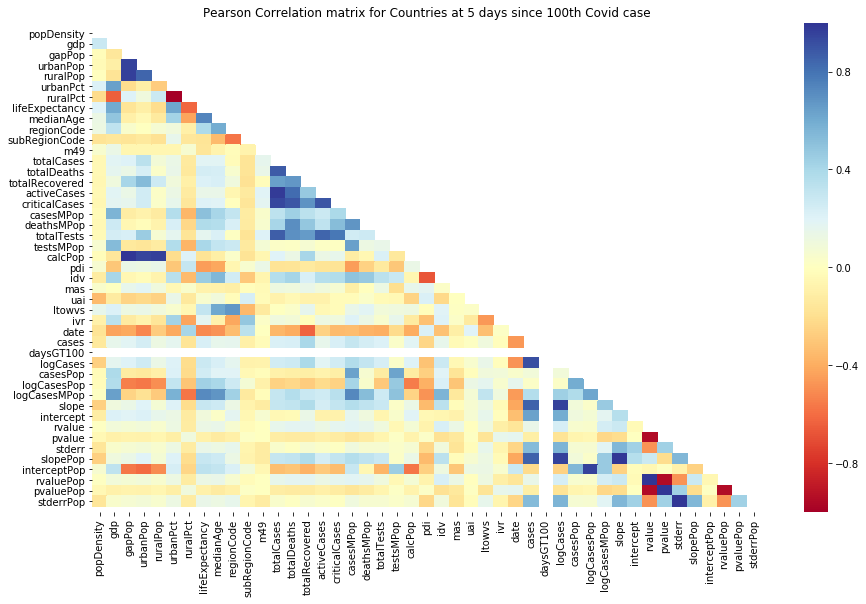

In [109]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr5)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr5,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

In [110]:
corr5.to_csv('corrcases5.csv')

## Create subset of Countries that have reached 10 days > 100 cases

In [111]:
cases10 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 10).sum())>0]

In [112]:
cases10 = cases10[cases10['daysGT100'] <= 10]

In [113]:
cases10.to_csv('cases10precalc.csv')

In [114]:
cases10group = cases10.groupby('code')

In [115]:
cases10slopes = (cases10group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop10slopes = (cases10group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [116]:
merged10 = merged_data[merged_data.daysGT100 == 10]

In [117]:
merged10.shape

(94, 45)

In [118]:
mergedcases10 = pd.merge(merged10, cases10slopes, on=["code"])
mergedcases10 = pd.merge(mergedcases10, casesPop10slopes, on=["code"])

In [119]:
# Export CSV
mergedcases10.to_csv('cases10.csv')  

In [120]:
corr10 = mergedcases10.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

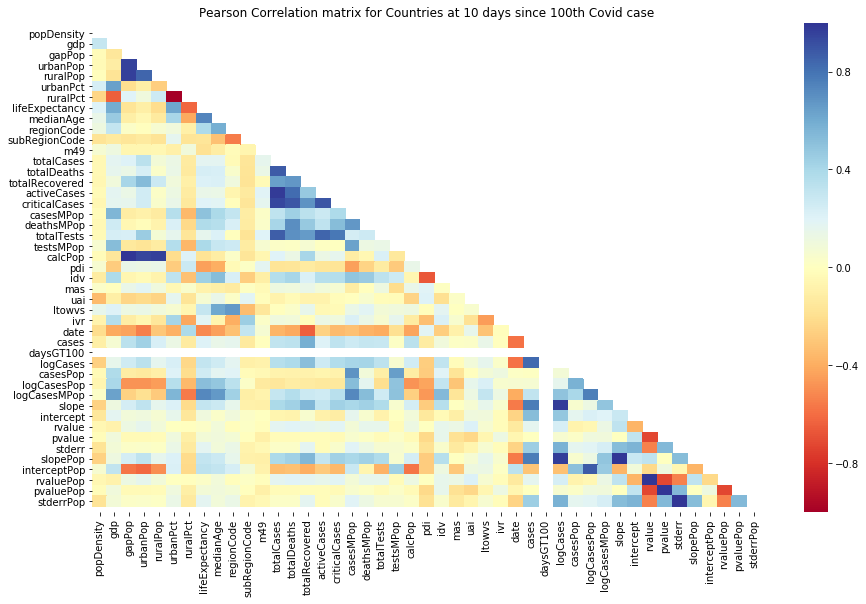

In [121]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr10)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr10,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

In [122]:
corr10.to_csv('corrcases10.csv')

## Create subset of Countries that have reached 20 days > 100 cases

In [123]:
cases20 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 20).sum())>0]

In [124]:
cases20 = cases20[cases20['daysGT100'] <= 20]

In [125]:
cases20.to_csv('cases20inter.csv')

In [126]:
cases20group = cases20.groupby('code')

In [127]:
cases20slopes = (cases20group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop20slopes = (cases20group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [128]:
cases20slopes.to_csv('cases20slopes.csv')

In [129]:
merged20 = merged_data[merged_data.daysGT100 == 20]

In [130]:
mergedcases20 = pd.merge(merged20, cases20slopes, on=["code"])
mergedcases20 = pd.merge(mergedcases20, casesPop20slopes, on=["code"])

In [131]:
# Export CSV
mergedcases20.to_csv('cases20.csv')  

In [132]:
corr20 = mergedcases20.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

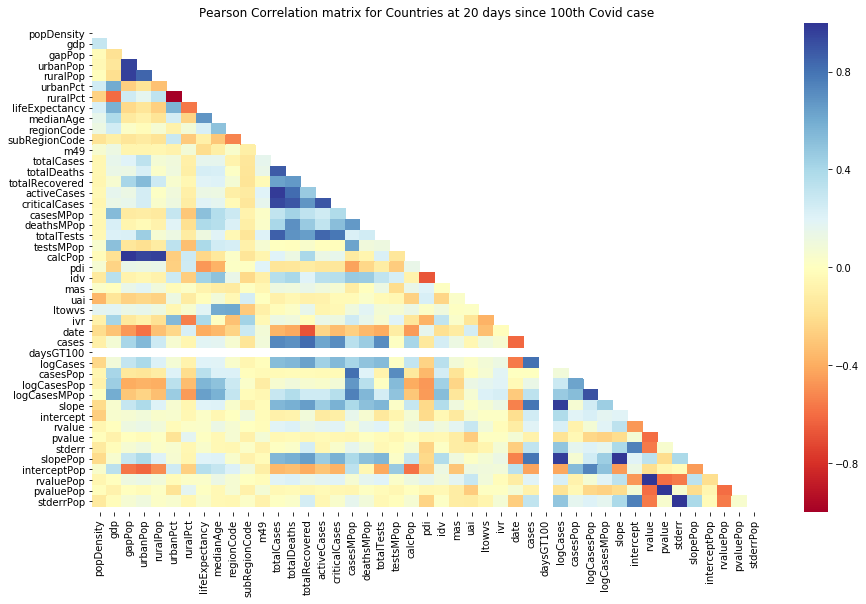

In [133]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr20)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr20,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

In [134]:
corr20.to_csv('corrcases20.csv')

## Create subset of Countries that have reached 30 days > 100 cases

In [135]:
cases30 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 30).sum())>0]

In [136]:
cases30 = cases30[cases30['daysGT100'] <= 30]

In [137]:
cases30group = cases30.groupby('code')

In [138]:
cases30slopes = (cases30group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop30slopes = (cases30group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [139]:
merged30 = merged_data[merged_data.daysGT100 == 30]

In [140]:
mergedcases30 = pd.merge(merged30, cases30slopes, on=["code"])
mergedcases30 = pd.merge(mergedcases30, casesPop30slopes, on=["code"])

In [141]:
# Export CSV
mergedcases30.to_csv('cases30.csv')  

In [142]:
corr30 = mergedcases30.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

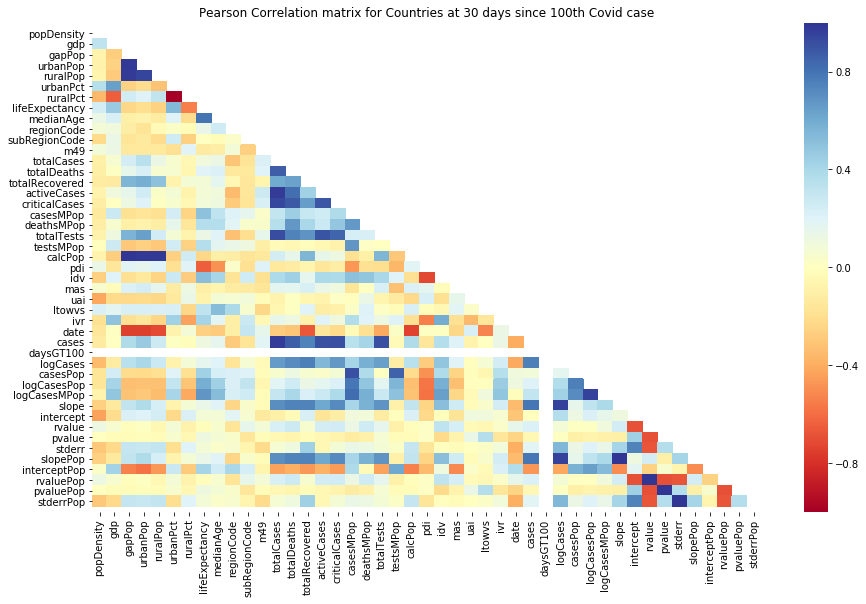

In [143]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr30)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr30,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

In [144]:
corr30.to_csv('corrcases30.csv')

## Create subset of Countries that have reached 35 days > 100 cases

In [145]:
cases35 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 35).sum())>0]

In [146]:
cases35 = cases35[cases35['daysGT100'] <= 35]

In [147]:
cases35group = cases35.groupby('code')

In [148]:
cases35slopes = (cases35group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop35slopes = (cases35group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [149]:
merged35 = merged_data[merged_data.daysGT100 == 35]

In [150]:
mergedcases35 = pd.merge(merged35, cases35slopes, on=["code"])
mergedcases35 = pd.merge(mergedcases35, casesPop35slopes, on=["code"])

In [151]:
# Export CSV
mergedcases35.to_csv('cases35.csv')  

In [152]:
corr35 = mergedcases35.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

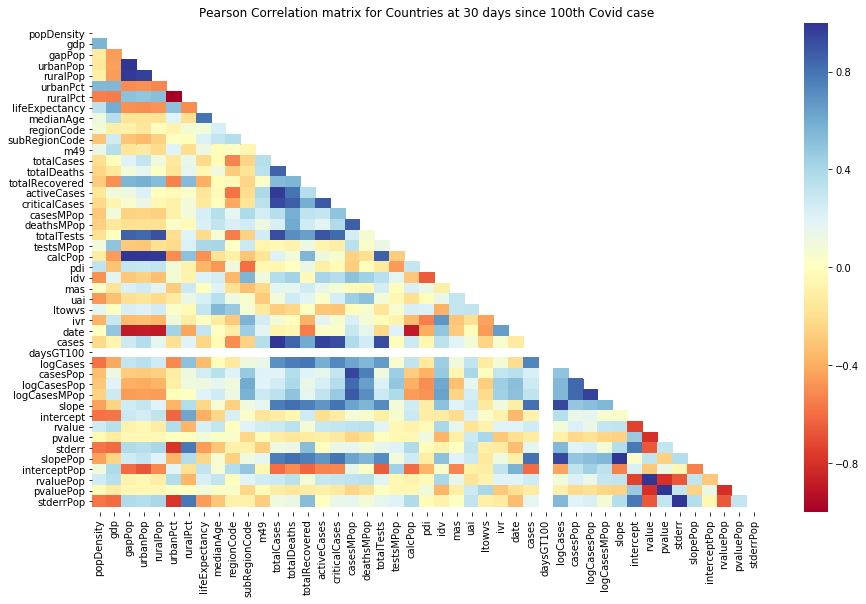

In [153]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr35)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr35,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

In [154]:
corr35.to_csv('corrcases35.csv')

## Create subset of Countries that have reached 40 days > 100 cases

In [155]:
cases40 = merged_data[merged_data.groupby('code')['daysGT100'].transform(lambda x: (x == 40).sum())>0]

In [156]:
cases40 = cases40[cases40['daysGT100'] <= 40]

In [157]:
#cases40.to_csv('cases40inter.csv')

In [158]:
cases40group = cases40.groupby('code')

In [159]:
cases40slopes = (cases40group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop40slopes = (cases40group.apply(lambda x: pd.Series(linregress(x['daysGT100'],x['logCasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [160]:
merged40 = merged_data[merged_data.daysGT100 == 40]

In [161]:
mergedcases40 = pd.merge(merged40, cases40slopes, on=["code"])
mergedcases40 = pd.merge(mergedcases40, casesPop40slopes, on=["code"])

In [162]:
# Export CSV
mergedcases40.to_csv('cases40.csv')  

In [163]:
corr40 = mergedcases40.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

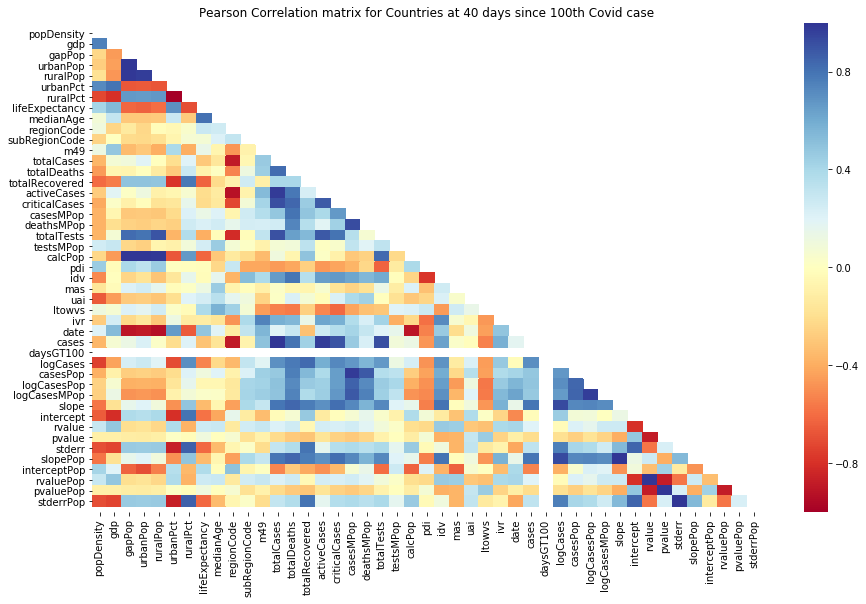

In [164]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr40)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr40,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

In [165]:
corr40.to_csv('corrcases40.csv')

### Concatonate the dataframes back together into one dataframe

In [166]:
# Concatonate all the dataframes 
cases_df = pd.concat([mergedcases40, mergedcases35, mergedcases30, mergedcases20, mergedcases10, mergedcases5])

In [167]:
mergedcases35.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country_x', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y',
       'date', 'cases', 'daysGT100', 'logCases', 'casesPop', 'logCasesPop',
       'logCasesMPop', 'slope', 'intercept', 'rvalue', 'pvalue', 'stderr',
       'slopePop', 'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [168]:
cases_df.head()

Entity code   popDensity           gdp        gapPop   urbanPop  \
0      China  CHN   146.057646  13569.891527  1.397029e+09  761027100   
1     France  FRA   121.619057  37766.374112  6.445720e+07   53044946   
2    Germany  DEU   234.153658  43937.947132  8.170779e+07   63062064   
3  Hong Kong  HKG  6944.095238  53591.835820  7.245701e+06    7291300   
4       Iran  IRN    48.724482  16500.900512  7.936049e+07   58217266   

    ruralPop  urbanPct   ruralPct  lifeExpectancy  ...     slope intercept  \
0  610192900    55.500  44.500000       76.092000  ...  0.143025  6.789809   
1   13548420    79.655  20.344999       82.273171  ...  0.167700  5.576819   
2   18624547    77.200  22.799999       80.641463  ...  0.181656  5.422000   
3          0   100.000   0.000000       84.278049  ...  0.070800  4.362908   
4   21143221    73.358  26.642000       75.730000  ...  0.121067  6.816901   

     rvalue        pvalue    stderr  slopePop interceptPop rvaluePop  \
0  0.915949  4.729206e-17  0.010034  0.143025   -14.301275  0.915949   
1  0.971502  5.407489e-26  0.006552  0.167700   -12.417403  0.971502   
2  0.973506  1.328237e-26  0.006832  0.181656   -12.821963  0.973506   
3  0.984331  5.212172e-31  0.002031  0.070800   -11.464560  0.984331   
4  0.926632  3.680392e-18  0.007866  0.121067   -11.429859  0.926632   

      pvaluePop stderrPop  
0  4.729206e-17  0.010034  
1  5.407489e-26  0.006552  
2  1.328237e-26  0.006832  
3  5.212172e-31  0.002031  
4  3.680392e-18  0.007866  

[5 rows x 55 columns]

In [169]:
cases_df.to_csv('cases_df.csv')

In [170]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country_x', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'country_y',
       'date', 'cases', 'daysGT100', 'logCases', 'casesPop', 'logCasesPop',
       'logCasesMPop', 'slope', 'intercept', 'rvalue', 'pvalue', 'stderr',
       'slopePop', 'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [171]:
cases_df.drop(['country_y'], axis=1,inplace=True)

In [172]:
cases_df = cases_df.rename(columns={'country_x': 'country'})

In [173]:
multi_slope = cases_df.set_index(['globalName','regionName','subRegionName','country'])

In [174]:

multi_slope = multi_slope.sort_index()
print(multi_slope.shape)
multi_slope.head()

(348, 50)


Entity code  popDensity  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Egypt      Egypt  EGY   94.206813   
                                      Egypt      Egypt  EGY   94.206813   

                                                        gdp      gapPop  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Egypt    10095.610168  93778172.0   
                                      Egypt    10095.610168  93778172.0   

                                               urbanPop  ruralPop  urbanPct  \
globalName regionName subRegionName   country                                 
World      Africa     Northern Africa Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Egypt    40122991  53655181    42.785   
                                      Egypt    40122991  53655181    42.785   

                                               ruralPct  lifeExpectancy  ...  \
globalName regionName subRegionName   country                            ...   
World      Africa     Northern Africa Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Egypt      57.215          71.304  ...   
                                      Egypt      57.215          71.304  ...   

                                                  slope  intercept    rvalue  \
globalName regionName subRegionName   country                                  
World      Africa     Northern Africa Algeria  0.134914   5.132275  0.976641   
                                      Algeria  0.171416   4.943417  0.970460   
                                      Algeria  0.201312   4.884338  0.906665   
                                      Egypt    0.096362   4.962887  0.994353   
                                      Egypt    0.099387   4.938429  0.985901   

                                                     pvalue    stderr  \
globalName regionName subRegionName   country                           
World      Africa     Northern Africa Algeria  3.781837e-14  0.006810   
                                      Algeria  7.341726e-07  0.014205   
                                      Algeria  1.266065e-02  0.046833   
                                      Egypt    8.283978e-30  0.001910   
                                      Egypt    3.238627e-16  0.003870   

                                               slopePop interceptPop  \
globalName regionName subRegionName   country                          
World      Africa     Northern Africa Algeria  0.134914   -12.469279   
                                      Algeria  0.171416   -12.658137   
                                      Algeria  0.201312   -12.717215   
                                      Egypt    0.096362   -13.500613   
                                      Egypt    0.099387   -13.525071   

                                               rvaluePop     pvaluePop  \
globalName regionName subRegionName   country                            
World      Africa     Northern Africa Algeria   0.976641  3.781837e-14   
                                      Algeria   0.970460  7.341726e-07   
       

### Function to easily do a panel of scatterplots easily

In [175]:
def makePanelScatterplot(data_df, x_data,y_data,color_col,split_col):
    x_label = x_data
    y_label = y_data
    ylim_min = data_df[y_data].min()*1.05
    ylim_max = data_df[y_data].max()*1.05
    xlim_min = data_df[x_data].min()*1.05
    xlim_max = data_df[x_data].max()*1.05

    g = sns.lmplot(x=x_data, y=y_data, data=data_df,\
           hue=color_col, col=split_col,col_wrap=3)

        
    g = (g.set_axis_labels(x_label, y_label)
          .set(ylim=(ylim_min, ylim_max),xlim=(xlim_min, xlim_max))
          .fig.subplots_adjust(wspace=.02))

# Slope of # Covid Cases vs. Power-Distance (PDI) of Culture

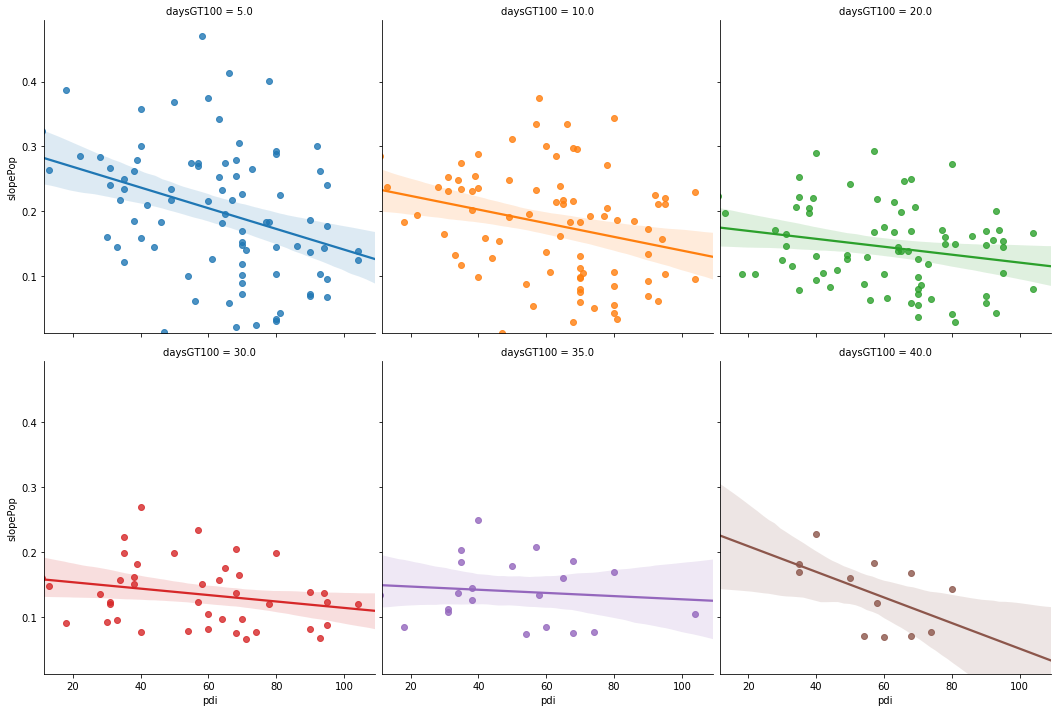

In [176]:
makePanelScatterplot(cases_df,"pdi","slopePop","daysGT100","daysGT100")

# Slope of # Covid Cases vs. Individualism/Collectivism of Culture

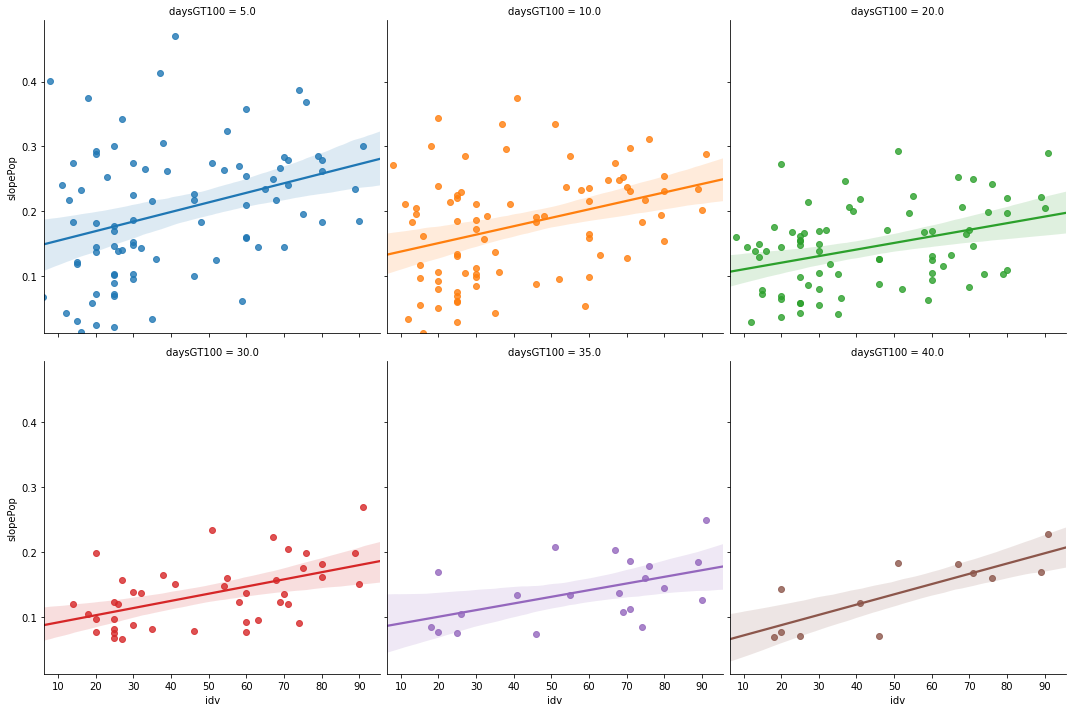

In [177]:
makePanelScatterplot(cases_df,"idv","slopePop","daysGT100","daysGT100")

# Slope of # Covid Cases vs. Indulgence (IVR) of Culture

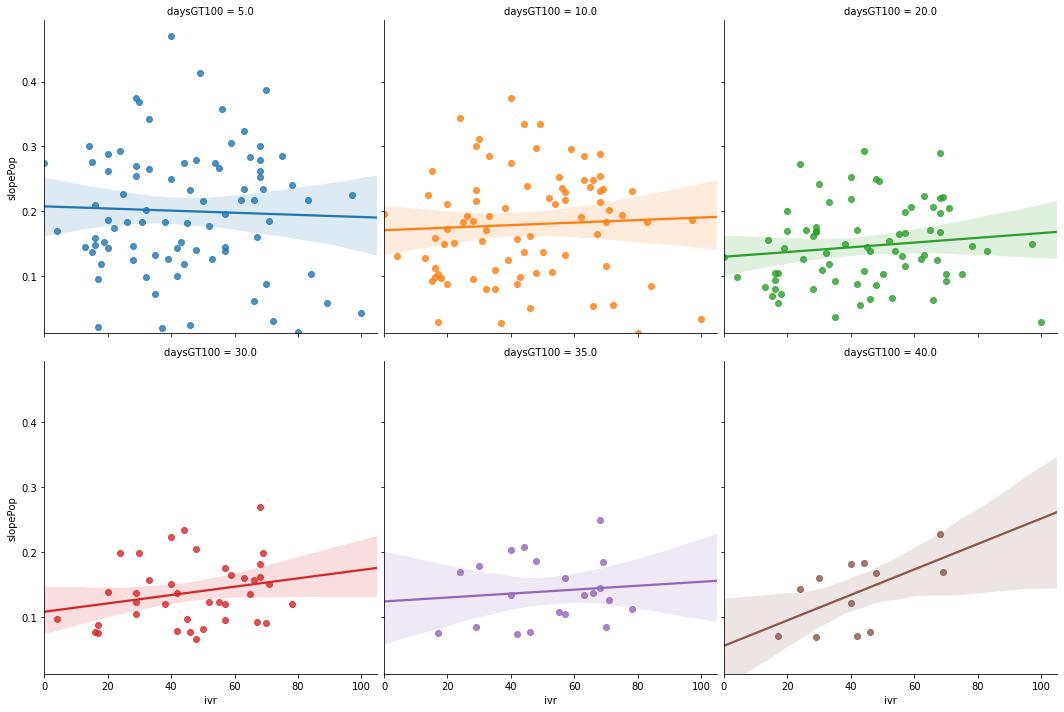

In [178]:
makePanelScatterplot(cases_df,"ivr","slopePop","daysGT100","daysGT100")

# Slope of # Covid Cases vs. Long-term Orientation (LTOWVS) of Culture

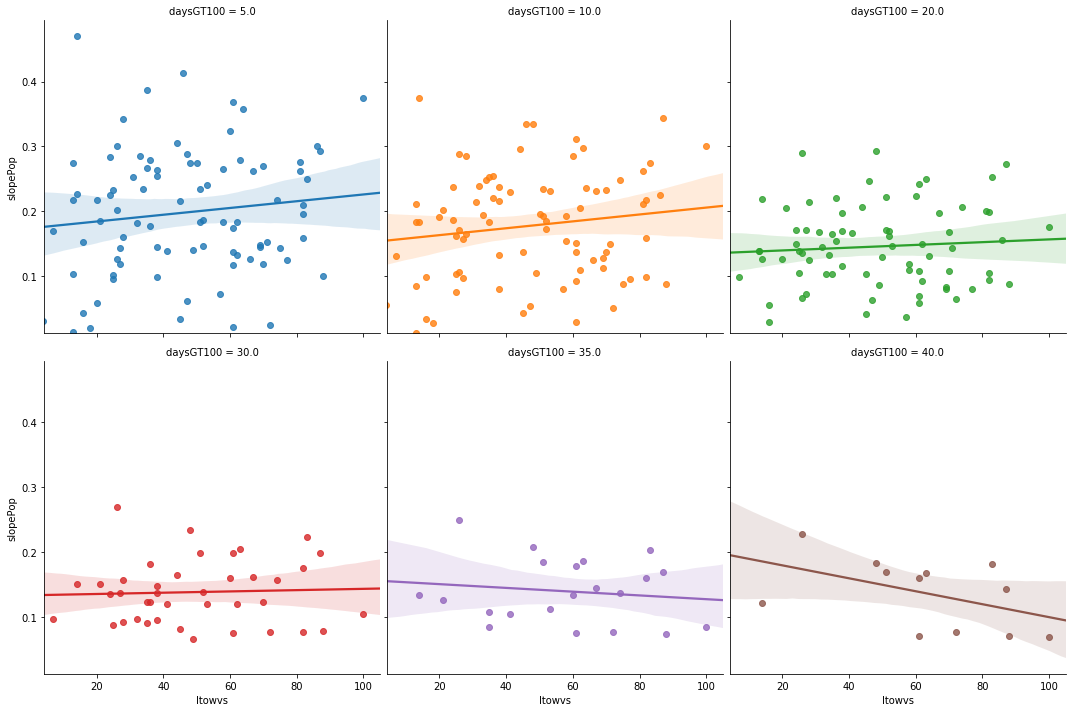

In [179]:
makePanelScatterplot(cases_df,"ltowvs","slopePop","daysGT100","daysGT100")

# Slope of # Covid Cases vs. Masculine/Feminine (MAS) of Culture

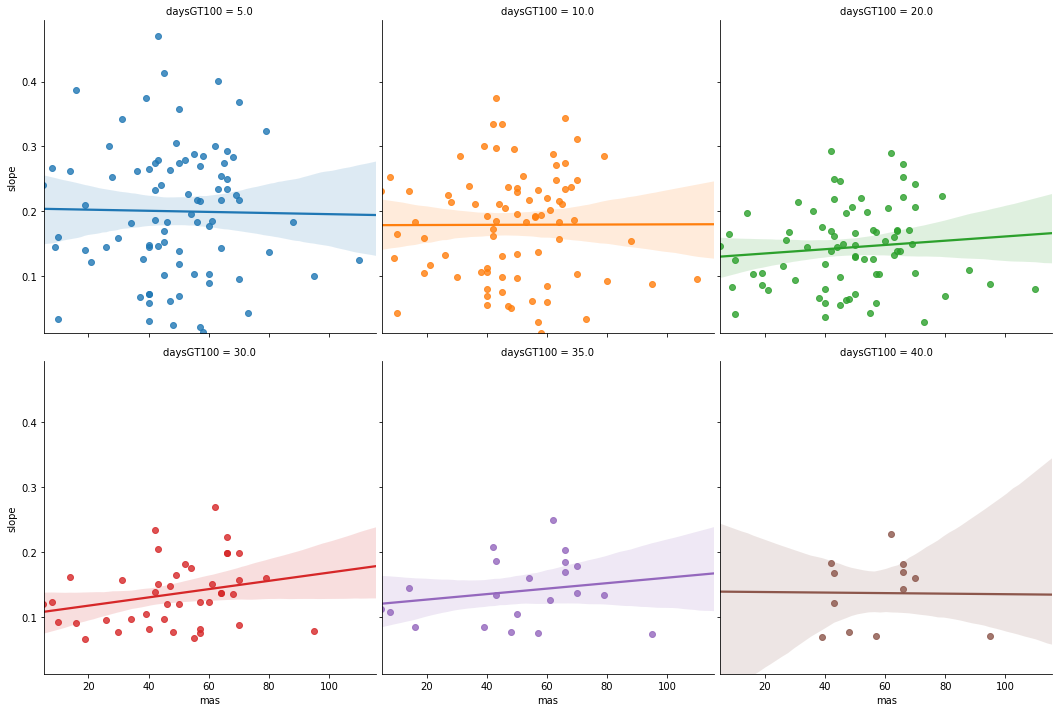

In [180]:
makePanelScatterplot(cases_df,"mas","slope","daysGT100","daysGT100")

# Slope of # Covid Cases vs. Uncertainty Avoidance (UAI) of Culture

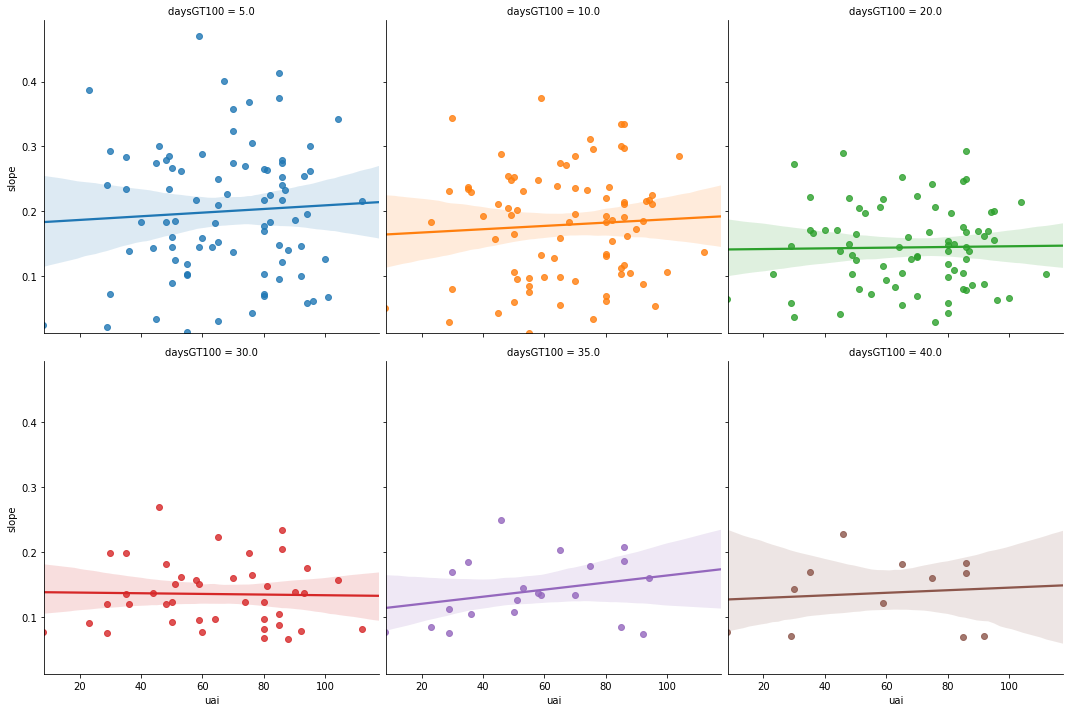

In [181]:
makePanelScatterplot(cases_df,"uai","slope","daysGT100","daysGT100")

In [182]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop',
       'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop',
       'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

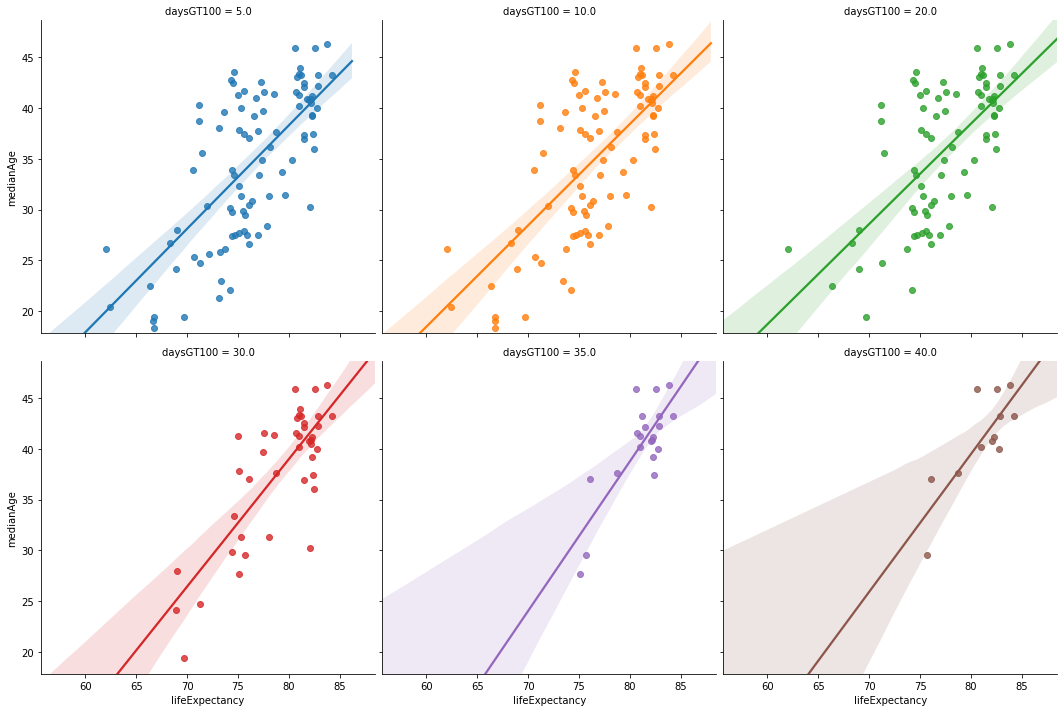

In [183]:
makePanelScatterplot(cases_df,"lifeExpectancy","medianAge","daysGT100","daysGT100")

# Change is

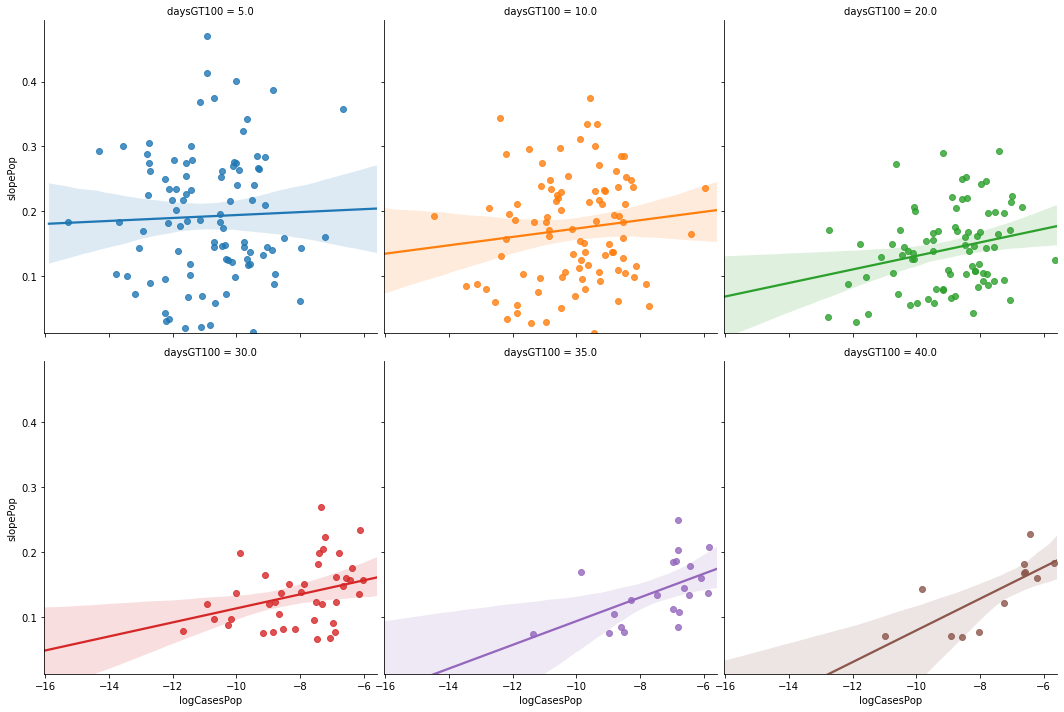

In [184]:
makePanelScatterplot(cases_df,"logCasesPop","slopePop","daysGT100","daysGT100")

In [185]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop',
       'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop',
       'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [186]:
multi_slope.head()

Entity code  popDensity  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Egypt      Egypt  EGY   94.206813   
                                      Egypt      Egypt  EGY   94.206813   

                                                        gdp      gapPop  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Egypt    10095.610168  93778172.0   
                                      Egypt    10095.610168  93778172.0   

                                               urbanPop  ruralPop  urbanPct  \
globalName regionName subRegionName   country                                 
World      Africa     Northern Africa Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Egypt    40122991  53655181    42.785   
                                      Egypt    40122991  53655181    42.785   

                                               ruralPct  lifeExpectancy  ...  \
globalName regionName subRegionName   country                            ...   
World      Africa     Northern Africa Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Egypt      57.215          71.304  ...   
                                      Egypt      57.215          71.304  ...   

                                                  slope  intercept    rvalue  \
globalName regionName subRegionName   country                                  
World      Africa     Northern Africa Algeria  0.134914   5.132275  0.976641   
                                      Algeria  0.171416   4.943417  0.970460   
                                      Algeria  0.201312   4.884338  0.906665   
                                      Egypt    0.096362   4.962887  0.994353   
                                      Egypt    0.099387   4.938429  0.985901   

                                                     pvalue    stderr  \
globalName regionName subRegionName   country                           
World      Africa     Northern Africa Algeria  3.781837e-14  0.006810   
                                      Algeria  7.341726e-07  0.014205   
                                      Algeria  1.266065e-02  0.046833   
                                      Egypt    8.283978e-30  0.001910   
                                      Egypt    3.238627e-16  0.003870   

                                               slopePop interceptPop  \
globalName regionName subRegionName   country                          
World      Africa     Northern Africa Algeria  0.134914   -12.469279   
                                      Algeria  0.171416   -12.658137   
                                      Algeria  0.201312   -12.717215   
                                      Egypt    0.096362   -13.500613   
                                      Egypt    0.099387   -13.525071   

                                               rvaluePop     pvaluePop  \
globalName regionName subRegionName   country                            
World      Africa     Northern Africa Algeria   0.976641  3.781837e-14   
                                      Algeria   0.970460  7.341726e-07   
       

In [187]:
multi_slope.to_csv('multi_slope_kip.csv')

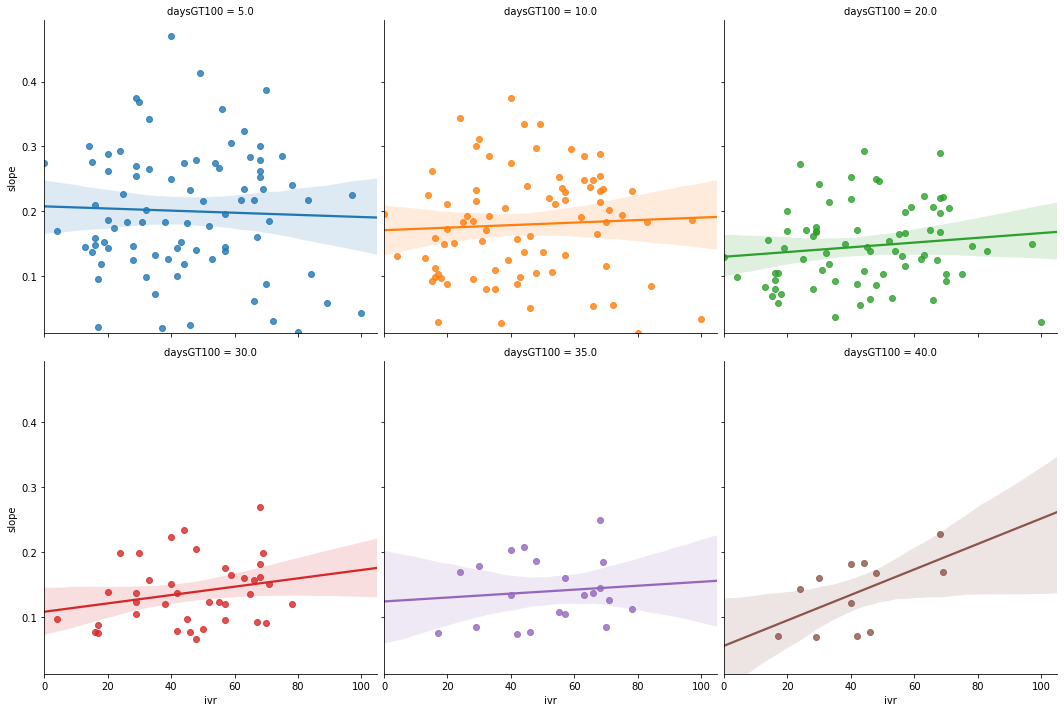

In [188]:
makePanelScatterplot(cases_df,"ivr","slope","daysGT100","daysGT100")

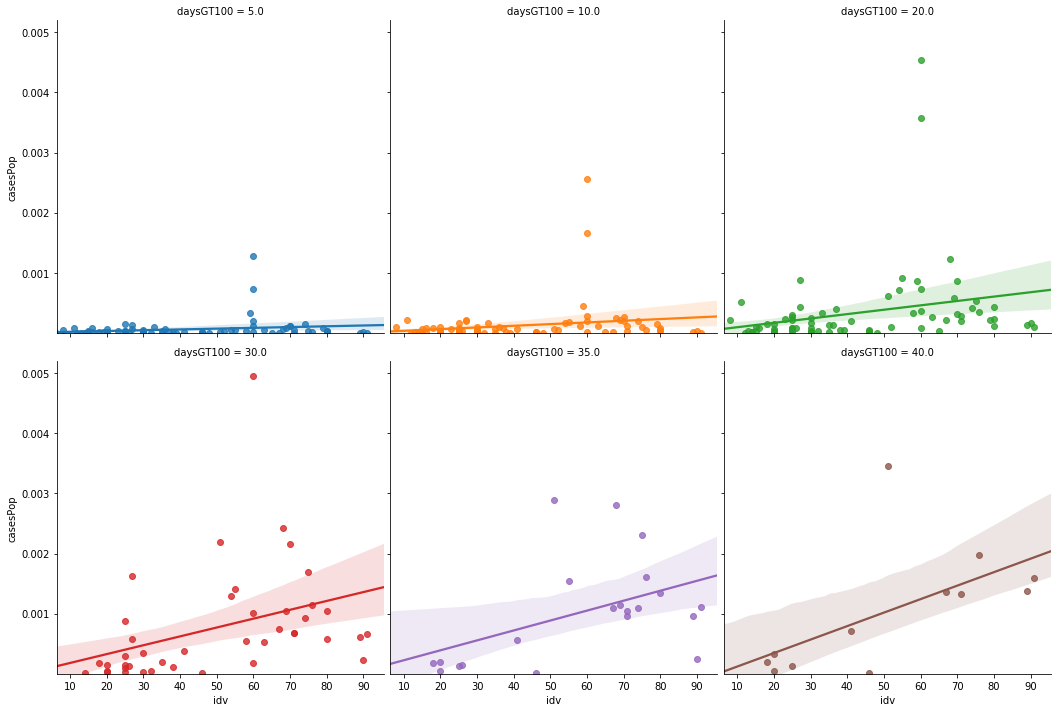

In [189]:
makePanelScatterplot(cases_df,"idv","casesPop","daysGT100","daysGT100")

In [190]:
def olsRegressionAnalysis (df,df_name,dep_col,ind_col):
    stat_dep_col = dep_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_ind_col = ind_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_col_list = [stat_dep_col,stat_ind_col]
    #print(f'stat_dep_col: {stat_dep_col}, stat_ind_col: {stat_ind_col}')
    col_list = [dep_col,ind_col]

    col_dict = {col_list[i]: stat_col_list[i] for i in range(len(col_list))} 
    #print(col_dict)
    stat_df = df[col_list].dropna()
    stat_df.rename(columns=col_dict,inplace=True)
    print(f'\u001b[34m{dep_col}\u001b[0m fitted against \u001b[34m{ind_col}\u001b[0m \
    using \x1b[31m{df_name}\x1b[0m dataframe:\n')
    print(f'We have {stat_df.shape[0]} rows left after dropping Null values\n')
    model_string = stat_dep_col + " ~ " + stat_ind_col
    all_model = ols(model_string, data=stat_df).fit()
    print(all_model.summary())

In [191]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop',
       'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop',
       'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [192]:
cases_df

Entity code   popDensity            gdp        gapPop  \
0                  China  CHN   146.057646   13569.891527  1.397029e+09   
1                 France  FRA   121.619057   37766.374112  6.445720e+07   
2                Germany  DEU   234.153658   43937.947132  8.170779e+07   
3              Hong Kong  HKG  6944.095238   53591.835820  7.245701e+06   
4                   Iran  IRN    48.724482   16500.900512  7.936049e+07   
5                  Italy  ITA   206.468287   34302.037403  5.950421e+07   
6                  Japan  JPN   348.751920   37882.980624  1.279750e+08   
7              Singapore  SGP  7806.772920   81741.096936  5.535262e+06   
8            South Korea  KOR   523.337577   34177.654470  5.059366e+07   
9                  Spain  ESP    92.846212   32291.155199  4.639766e+07   
10        United Kingdom  GBR   269.205394   38839.166957  6.539708e+07   
11         United States  USA    35.096217   53005.636146  3.199292e+08   
0              Australia  AUS     3.104641   43923.258269  2.379956e+07   
1                Austria  AUT   104.730790   44304.967757  8.678657e+06   
2                Belgium  BEL   372.331440   41708.212340  1.128794e+07   
3                  China  CHN   146.057646   13569.891527  1.397029e+09   
4                Denmark  DNK   135.353251   45458.697149  5.688695e+06   
5                 France  FRA   121.619057   37766.374112  6.445720e+07   
6                Germany  DEU   234.153658   43937.947132  8.170779e+07   
7              Hong Kong  HKG  6944.095238   53591.835820  7.245701e+06   
8                   Iran  IRN    48.724482   16500.900512  7.936049e+07   
9                  Italy  ITA   206.468287   34302.037403  5.950421e+07   
10                 Japan  JPN   348.751920   37882.980624  1.279750e+08   
11              Malaysia  MYS    93.511353   25001.612673  3.072316e+07   
12           Netherlands  NLD   502.817542   46494.364258  1.693850e+07   
13                Norway  NOR    14.210294   64008.286830  5.199836e+06   
14             Singapore  SGP  7806.772920   81741.096936  5.535262e+06   
15           South Korea  KOR   523.337577   34177.654470  5.059366e+07   
16                 Spain  ESP    92.846212   32291.155199  4.639766e+07   
17                Sweden  SWE    24.058300   45679.277997  9.763565e+06   
..                   ...  ...          ...            ...           ...   
67                  Peru  PER    24.513024   11770.034448  3.137667e+07   
68           Philippines  PHL   341.135456    6874.582566  1.017164e+08   
69                Poland  POL   124.061570   25299.974348  3.826523e+07   
70              Portugal  PRT   113.072026   26607.833123  1.041847e+07   
71                 Qatar  QAT   213.741516  119749.428536  2.481539e+06   
72               Romania  ROU    86.124309   20556.003642  1.987662e+07   
73                Russia  RUS     8.798804   24516.549950  1.438880e+08   
74                Rwanda  RWA   471.404662    1731.043423  1.162955e+07   
75          Saudi Arabia  SAU    14.679858   50723.712645  3.155714e+07   
76               Senegal  SEN    77.790443    2293.853539  1.497699e+07   
77                Serbia  SRB    81.127178   13277.800117  8.851280e+06   
78             Singapore  SGP  7806.772920   81741.096936  5.535262e+06   
79              Slovakia  SVK   112.803149   28308.879770  5.439318e+06   
80              Slovenia  SVN   102.459335   29037.741676  2.074788e+06   
81          South Africa  ZAF    45.578832   12377.659260  5.529122e+07   
82           South Korea  KOR   523.337577   34177.654470  5.059366e+07   
83                 Spain  ESP    92.846212   32291.155199  4.639766e+07   
84             Sri Lanka  LKA   334.332642   11079.710677  2.071404e+07   
85                Sweden  SWE    24.058300   45679.277997  9.763565e+06   
86           Switzerland  CHE   209.596012   57264.157397  8.319769e+06   
87              Thailand  THA   134.388224   15252.228253  6.865760e+07   
88   Trinidad and Tobago  TTO   265.125146 

In [193]:
# # Create tidy datasets for Country then Covid
# country_cols = ['Entity', 'Code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
#        'urbanPct', 'ruralPct', 'lifeExpectancy', 'globalCode', 'globalName',
#        'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
#        'interRegionCode', 'interRegionName', 'country', 'm49', 'ldc', 'lldc',
#        'sids', 'development', 'countryWom', 'calcPop', 'medianAge', 'pdi',
#        'idv', 'mas', 'uai', 'ltowvs', 'ivr']
# countries = cases_df[country_cols].drop_duplicates()
# countries = countries.reset_index(drop=True)
# countries = countries.set_index(['Code'])
# countries.head()

In [194]:
countries.columns

Index(['globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'code', 'ldc', 'lldc', 'sids', 'development', 'pdi', 'idv', 'mas',
       'uai', 'ltowvs', 'ivr'],
      dtype='object')

In [195]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop',
       'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop',
       'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [196]:
# Create Covid cases table
covid_vc = pd.merge(cases_df, countries, on=['globalName',
       'regionCode', 'regionName', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr'])
covid_vc.columns

Index(['Entity', 'code_x', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge',
       'globalName', 'regionCode', 'regionName', 'subRegionCode_x',
       'subRegionName', 'interRegionName', 'country', 'm49', 'development',
       'countryWom', 'totalCases', 'totalDeaths', 'totalRecovered',
       'activeCases', 'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests',
       'testsMPop', 'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr',
       'date', 'cases', 'daysGT100', 'logCases', 'casesPop', 'logCasesPop',
       'logCasesMPop', 'slope', 'intercept', 'rvalue', 'pvalue', 'stderr',
       'slopePop', 'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop',
       'globalCode', 'subRegionCode_y', 'interRegionCode', 'code_y', 'ldc',
       'lldc', 'sids'],
      dtype='object')

In [197]:
covid_vc.drop(['code_y'], axis=1,inplace=True)

In [198]:
covid_vc = covid_vc.rename(columns={'code_x': 'code'})

In [199]:
covid_vc = covid_vc[['code','date', 'cases', 'daysGT100',
       'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop', 'slope',
       'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop', 'interceptPop',
       'rvaluePop', 'pvaluePop', 'stderrPop']]
covid_vc

code        date     cases  daysGT100   logCases      casesPop  \
0    CHN  1582848000   78927.0       40.0  11.276279  5.463668e-05   
1    CHN  1582416000   77016.0       35.0  11.251768  5.331380e-05   
2    CHN  1581984000   72508.0       30.0  11.191452  5.019317e-05   
3    CHN  1581120000   34625.0       20.0  10.452331  2.396892e-05   
4    CHN  1580256000    5994.0       10.0   8.698514  4.149306e-06   
5    CHN  1579824000     882.0        5.0   6.782192  6.105585e-07   
6    FRA  1586476800   86334.0       40.0  11.365979  1.322484e-03   
7    FRA  1586044800   68605.0       35.0  11.136121  1.050907e-03   
8    FRA  1585612800   44550.0       30.0  10.704367  6.824273e-04   
9    FRA  1584748800   12612.0       20.0   9.442404  1.931936e-04   
10   FRA  1583884800    1784.0       10.0   7.486613  2.732773e-05   
11   FRA  1583452800     423.0        5.0   6.047372  6.479613e-06   
12   DEU  1586476800  113525.0       40.0  11.639778  1.354687e-03   
13   DEU  1586044800   91714.0       35.0  11.426430  1.094418e-03   
14   DEU  1585612800   61913.0       30.0  11.033485  7.388044e-04   
15   DEU  1584748800   18187.0       20.0   9.808462  2.170245e-04   
16   DEU  1583884800    1296.0       10.0   7.167038  1.546510e-05   
17   DEU  1583452800     400.0        5.0   5.991465  4.773178e-06   
18   HKG  1586649600    1004.0       40.0   6.911747  1.342616e-04   
19   HKG  1586217600     935.0       35.0   6.840547  1.250344e-04   
20   HKG  1585785600     784.0       30.0   6.664409  1.048417e-04   
21   HKG  1584921600     351.0       20.0   5.860786  4.693805e-05   
22   HKG  1584057600     132.0       10.0   4.882802  1.765192e-05   
23   HKG  1583625600     113.0        5.0   4.727388  1.511111e-05   
24   IRN  1586217600   60500.0       40.0  11.010399  7.199269e-04   
25   IRN  1585785600   47593.0       35.0  10.770441  5.663386e-04   
26   IRN  1585353600   32332.0       30.0  10.383813  3.847385e-04   
27   IRN  1584489600   16169.0       20.0   9.690851  1.924049e-04   
28   IRN  1583625600    5823.0       10.0   8.669571  6.929148e-05   
29   IRN  1583193600    1501.0        5.0   7.313887  1.786133e-05   
..   ...         ...       ...        ...        ...           ...   
318  VNM  1586649600     258.0       20.0   5.552960  2.888060e-06   
319  VNM  1585785600     235.0       10.0   5.459586  2.630597e-06   
320  VNM  1585353600     169.0        5.0   5.129899  1.891791e-06   
321  AZE  1586131200     584.0       10.0   6.369901  5.779409e-05   
322  AZE  1585699200     298.0        5.0   5.697093  2.949082e-05   
323  BLR  1586476800    1486.0       10.0   7.303843  1.574490e-04   
324  BLR  1586044800     394.0        5.0   5.976351  4.174624e-05   
325  GEO  1586563200     234.0       10.0   5.455321  5.888235e-05   
326  GEO  1586131200     174.0        5.0   5.159055  4.378431e-05   
327  GHA  1586131200     214.0       10.0   5.365976  7.010920e-06   
328  GHA  1585699200     152.0        5.0   5.023881  4.979719e-06   
329  HND  1586304000     312.0       10.0   5.743003  3.149296e-05   
330  HND  1585872000     222.0        5.0   5.402677  2.240845e-05   
331  KEN  1586736000     197.0       10.0   5.283204  3.502222e-06   
332  KEN  1586304000     172.0        5.0   5.147494  3.057778e-06   
333  KGZ  1586563200     339.0       10.0   5.826000  5.209577e-05   
334  KGZ  1586131200     216.0        5.0   5.375278  3.319377e-05   
335  MNE  1586563200     257.0       10.0   5.549076  4.095937e-04   
336  MNE  1586131200     214.0        5.0   5.365976  3.410625e-04   
337  NGA  1586476800     288.0       10.0   5.662960  1.415233e-06   
338  NGA  1586044800     210.0        5.0   5.347108  1.031941e-06   
339  RWA  1586908800     134.0       10.0   4.897840  1.083824e-05   
340  RWA  1586476800     113.0        5.0   4.727388  9.139706e-06   
341  SEN  1586131200     222.0       10.0   5.402677  1.343312e-05   
342  SEN  1585699200     175.0        5.0   5.164786  1.058917e-05   
343  TTO  1586

In [200]:
tidy_df = cases_df.melt(id_vars="daysGT100")

In [201]:
cases_df.head()

Entity code   popDensity           gdp        gapPop   urbanPop  \
0      China  CHN   146.057646  13569.891527  1.397029e+09  761027100   
1     France  FRA   121.619057  37766.374112  6.445720e+07   53044946   
2    Germany  DEU   234.153658  43937.947132  8.170779e+07   63062064   
3  Hong Kong  HKG  6944.095238  53591.835820  7.245701e+06    7291300   
4       Iran  IRN    48.724482  16500.900512  7.936049e+07   58217266   

    ruralPop  urbanPct   ruralPct  lifeExpectancy  ...     slope intercept  \
0  610192900    55.500  44.500000       76.092000  ...  0.143025  6.789809   
1   13548420    79.655  20.344999       82.273171  ...  0.167700  5.576819   
2   18624547    77.200  22.799999       80.641463  ...  0.181656  5.422000   
3          0   100.000   0.000000       84.278049  ...  0.070800  4.362908   
4   21143221    73.358  26.642000       75.730000  ...  0.121067  6.816901   

     rvalue        pvalue    stderr  slopePop interceptPop rvaluePop  \
0  0.915949  4.729206e-17  0.010034  0.143025   -14.301275  0.915949   
1  0.971502  5.407489e-26  0.006552  0.167700   -12.417403  0.971502   
2  0.973506  1.328237e-26  0.006832  0.181656   -12.821963  0.973506   
3  0.984331  5.212172e-31  0.002031  0.070800   -11.464560  0.984331   
4  0.926632  3.680392e-18  0.007866  0.121067   -11.429859  0.926632   

      pvaluePop stderrPop  
0  4.729206e-17  0.010034  
1  5.407489e-26  0.006552  
2  1.328237e-26  0.006832  
3  5.212172e-31  0.002031  
4  3.680392e-18  0.007866  

[5 rows x 54 columns]

In [202]:
cases_df.columns

Index(['Entity', 'code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'medianAge', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionName', 'country', 'm49', 'development', 'countryWom',
       'totalCases', 'totalDeaths', 'totalRecovered', 'activeCases',
       'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop',
       'calcPop', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'date', 'cases',
       'daysGT100', 'logCases', 'casesPop', 'logCasesPop', 'logCasesMPop',
       'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'slopePop',
       'interceptPop', 'rvaluePop', 'pvaluePop', 'stderrPop'],
      dtype='object')

In [204]:
df = cases_df[cases_df['daysGT100'] >= 30].sort_values(by=['casesPop'])

fig = px.scatter(df, x="country", y="casesPop", color="idv", 
              color_continuous_scale= px.colors.sequential.Inferno,
              title="Confirmed Covid cases per Capita vs. Hoefstede 'Individualism' Score",
             hover_name="country", hover_data=['cases','slope','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))


fig.show()

In [239]:
womHoef.columns

Index(['countryWom', 'code', 'date', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'country', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'casesPop', 'logCasesPop',
       'logCasesMPop', 'daysGT100'],
      dtype='object')

In [247]:
df = womHoef.dropna(subset=['idv'],inplace=True)
df = womHoef[womHoef['activeCases'] >= 400].sort_values(by=['casesPop'])


fig = px.scatter(df, x="daysGT100", y="casesPop", color="idv", 
              color_continuous_scale= px.colors.sequential.Inferno,
              title="Confirmed Covid cases per Capita vs. Hoefstede 'Individualism' Score",
             hover_name="country", hover_data=['totalCases','idv','ivr','pdi'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))


fig.show()

In [260]:
# username = 'cosapient' # your username
# api_key = '6b3SyxmQGIbN1ieEiAUZ' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=plotly_api_key)

In [261]:
py.plot(fig, filename = 'casesPop_daysGT100_idv', auto_open=True)

AttributeError: module 'chart_studio' has no attribute 'plot'

In [263]:

df = womHoef[womHoef['testsMPop'] < 30000].sort_values(by=['casesPop'])
df.dropna(subset=['idv'],inplace=True)

fig = px.scatter(df, x="testsMPop", y="casesPop", color="idv", 
              color_continuous_scale= px.colors.sequential.Inferno,
              title="Confirmed Covid cases per Capita vs. Hoefstede 'Individualism' Score",
             hover_name="country", hover_data=['totalCases','idv','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))


fig.show()

In [264]:

df = womHoef[womHoef['testsMPop'] < 30000].sort_values(by=['casesPop'])
df.dropna(subset=['idv'],inplace=True)

fig = px.scatter(df, x="idv", y="casesPop", color="idv", 
              color_continuous_scale= px.colors.sequential.Inferno,
              title="Confirmed Covid cases per Capita vs. Hoefstede 'Individualism' Score",
             hover_name="country", hover_data=['totalCases','idv','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))


fig.show()

In [265]:
df = cases_df[cases_df['daysGT100'] >= 35]

fig = px.line(df, x="daysGT100", y="slope", color="country", title="layout.hovermode='x unified'",
             hover_name="country", hover_data=['country','slope','ivr'])
fig.update_traces(mode="markers+lines")


fig.show()

In [266]:
covidGT100Hoef.columns

Index(['code', 'country', 'date', 'cases', 'daysGT100', 'logCases',
       'globalCode', 'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'm49', 'ldc',
       'lldc', 'sids', 'development', 'pdi', 'idv', 'mas', 'uai', 'ltowvs',
       'ivr', 'countryWom', 'totalCases', 'totalDeaths', 'totalRecovered',
       'activeCases', 'criticalCases', 'casesMPop', 'deathsMPop', 'totalTests',
       'testsMPop', 'calcPop', 'casesPop', 'logCasesPop', 'logCasesMPop'],
      dtype='object')

In [267]:
df = covidGT100Hoef.dropna(subset=['idv'],inplace=True)

df = covidGT100Hoef[covidGT100Hoef['cases'] >= 100].sort_values(by=['idv'])

fig = px.scatter(df, x="daysGT100", y="casesPop", color="idv", 
              title="Covid Confirmed cases vs. # Days Country had 100th case",
             hover_name="country", hover_data=['cases','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))

fig.update_layout( yaxis_type="log")
fig.show()

In [268]:
# username = 'cosapient' # your username
# api_key = '6b3SyxmQGIbN1ieEiAUZ' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=plotly_api_key)

In [269]:
py.plot(fig, filename = 'cases_dayGT100_idv', auto_open=True)

AttributeError: module 'chart_studio' has no attribute 'plot'

In [ ]:
covidGT100Hoef.columns

In [ ]:


df = covidGT100Hoef[covidGT100Hoef['idv'] > 50].sort_values(by=['idv'])
df.dropna(subset=['idv'],inplace=True)

fig = px.scatter(df, x="daysGT100", y="casesPop", color="idv", 
              title="Covid Confirmed cases vs. # Days Country had 100th case",
             hover_name="country", hover_data=['cases','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))

fig.update_layout( yaxis_type="log")
fig.show()

In [ ]:
womHoef.shape

In [ ]:

df = womHoef[womHoef['testsMPop'] < 30000].sort_values(by=['casesPop'])
df.dropna(subset=['idv'],inplace=True)
fig = px.scatter(df, x="idv", y="casesPop", color="idv", 
              color_continuous_scale= px.colors.sequential.Inferno,
              title="Confirmed Covid cases per Capita vs. Hoefstede 'Individualism' Score",
             hover_name="country", hover_data=['totalCases','idv','ivr'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode="markers"))


fig.show()

In [ ]:

#merged_data['slope'] = merged_data.groupby('Code').diff()(lambda v: linregress(v.Date, v.cases)[0])
merged_data['slope'] = (merged_data.groupby('code')[['date','logCases']].expanding().apply(lambda x: linregress(x['Date'],x['cases'])[0]))
#merged_data['slope'] = (merged_data.groupby('Code')['Date','cases'].apply(lambda x,y : x.shift().expanding().apply(lambda v: linregress([0], [1])[0])))

In [ ]:
#jupyter nbconvert merge_data_modified.ipynb --to html --output covidCulture.html